### Naive installation of libraries

In [26]:
!conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia -y

^C


In [1]:
!pip install -qU chardet numpy==1.24.3 pandas==2.0.2 matplotlib==3.7.1 seaborn==0.12.2 pydicom==2.3.1 pylibjpeg==1.4.0 opencv-python==4.7.0.72 pyyaml==6.0 ultralytics==8.0.113

### Imports

In [2]:
# Basic
import os
import numpy as np
import pandas as pd
from os.path import join as pjoin
from pathlib import Path
import cv2 as cv

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import pydicom
from pydicom.pixel_data_handlers.util import apply_modality_lut
from pydicom.pixel_data_handlers.util import apply_voi_lut

### Dataset Description
#### Columns
- StudyInstanceUID: Study ID for each student
- patient_overall: If any of the columns are fractured
- C1..C7: Ocurrence of column fracture

### Load data

In [3]:
train_df = pd.read_csv("./dataset/train.csv")
train_df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0


In [4]:
n_unique_positive_studies = len(train_df.loc[train_df["patient_overall"] == 1]["StudyInstanceUID"].unique())
n_unique_negative_studies = len(train_df.loc[train_df["patient_overall"] == 0]["StudyInstanceUID"].unique())

print(f"Number of unique negative (absence) studies: {n_unique_negative_studies}")
print(f"Number of unique positive (presence) studies: {n_unique_positive_studies}")
print(f"Total number of unique studies: {n_unique_positive_studies + n_unique_negative_studies}")

Number of unique negative (absence) studies: 1058
Number of unique positive (presence) studies: 961
Total number of unique studies: 2019


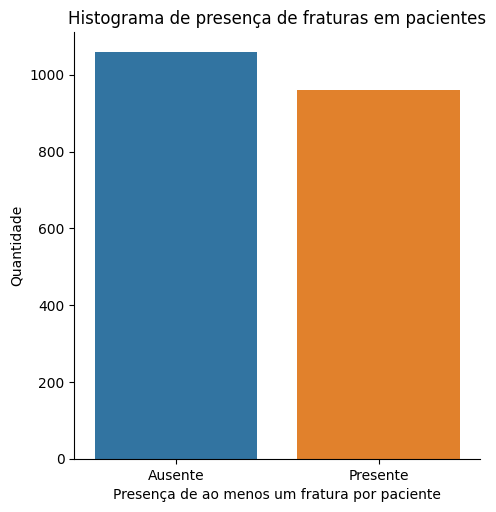

In [5]:
sns_plot = sns.catplot(data=train_df, x="patient_overall", kind="count")
sns_plot.set_axis_labels("Presença de ao menos um fratura por paciente", "Quantidade")
sns_plot.set_xticklabels(labels=["Ausente", "Presente"])
plt.title("Histograma de presença de fraturas em pacientes")
plt.show()

The amount of fractures per study is almost balanced (~50%)

In [6]:
train_df.loc[train_df["patient_overall"] == 1].head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
5,1.2.826.0.1.3680043.4859,1,0,0,0,0,0,1,0


## Load Train BB

In [7]:
train_bb_df = pd.read_csv("./dataset/train_bounding_boxes.csv")

In [8]:
train_bb_df.head()

,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137


#### ID de pacientes com fraturas com bb

In [9]:
# Tamanho da amostra em recortes
# IDs únicos de pacientes com fraturas com bb
# study_uid_bb_unique = len(train_bb_df["])
unique_studies_with_bb = train_bb_df["StudyInstanceUID"].unique()
# print(f"Amount of unique studies with bb: {n_unique_studies_with_bb}")
print(f"Amount of slices with bb: {len(train_bb_df)}")
print(f"Amount of unique studies with bb: {len(unique_studies_with_bb)}")

Amount of slices with bb: 7217
Amount of unique studies with bb: 235


In [10]:
# Study ids which fractures are absent
study_uid_with_fracture_absent = train_df.loc[train_df["patient_overall"] == 0].StudyInstanceUID

# Study ids which fractures are present
study_uid_with_fracture_present = train_df.loc[train_df["patient_overall"] == 1].StudyInstanceUID

# Number of unique patient ids without fracture
set_study_uid_with_fracture_absent = set(study_uid_with_fracture_absent.unique())
set_study_uid_with_fracture_present = set(study_uid_with_fracture_present.unique())

print(f"Number of unique studies with fractures present: {len(set_study_uid_with_fracture_present)}")
print(f"Number of unique studies with fractures absent: {len(set_study_uid_with_fracture_absent)}")

Number of unique studies with fractures present: 961
Number of unique studies with fractures absent: 1058


In [11]:
images_path = pjoin(os.getcwd(), "dataset", "train_images")

# It is not possible to accurately determine the amount of fractures per study (patient),
# we only know which vertabrae are fractured, but its presence among the slices.

n_slices_with_fracture = 0
n_slices_without_fracture = 0

for dirpath, dirnames, filenames in os.walk(images_path):
    target_name = Path(dirpath).name
    if target_name in set_study_uid_with_fracture_present:
        n_slices_with_fracture += len(filenames)
    elif target_name in set_study_uid_with_fracture_absent:
        n_slices_without_fracture += len(filenames)

print(f"Total num slices: {n_slices_with_fracture + n_slices_without_fracture}\nNum slices of patient with at least one fracture: {n_slices_with_fracture}\nNum slices of patients without any fractures: {n_slices_without_fracture}")

Total num slices: 711601
Num slices of patient with at least one fracture: 320919
Num slices of patients without any fractures: 390682


### Histogram of fractures per spine section

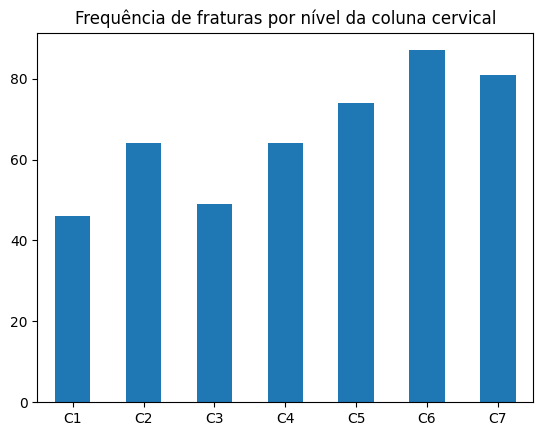

In [12]:
tmp_df = train_df.loc[(train_df["patient_overall"] == 1) & (train_df["StudyInstanceUID"].isin(list(unique_studies_with_bb)))]
target_columns = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
plt.title("Frequência de fraturas por nível da coluna cervical")
tmp_df[target_columns].sum().plot(kind="bar", rot=0)
plt.show()

In [13]:
n_slices_per_study = dict()
for study_id in os.listdir(images_path):
    files = [file for file in os.listdir(os.path.join(images_path, study_id)) if file.endswith(".dcm")]
    n_slices_per_study[study_id] = len(files)
pd.Series(n_slices_per_study)

slices_per_study = pd.Series(n_slices_per_study).describe()
mean_slices_per_study = slices_per_study["mean"]
std_slices_per_study = slices_per_study["std"]
print(f"There are {mean_slices_per_study:.2f} slices on average per study, with and std of {std_slices_per_study:.2f} slices.")

There are 352.45 slices on average per study, with and std of 132.01 slices.


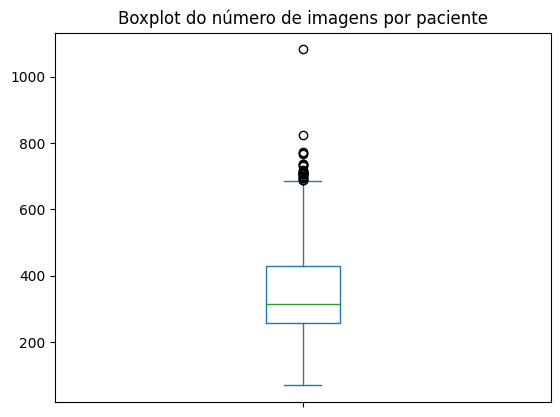

In [14]:
ax = pd.Series(n_slices_per_study).plot.box()
ax.set_title("Boxplot do número de imagens por paciente")
plt.show()

In [15]:
def preprocess_single_image(dicom_file_path, resize=True, target_resize=512):
    ds = pydicom.dcmread(dicom_file_path)
    hu = apply_modality_lut(ds.pixel_array, ds)
    hu_windowed = apply_voi_lut(hu, ds)

    if resize and (hu_windowed.shape[0] != target_resize or hu_windowed.shape[1] != target_resize):
        hu_windowed = cv.resize(hu_windowed, (target_resize, target_resize))

    hu_windowed = (hu_windowed - np.min(hu_windowed)) / (np.max(hu_windowed) - np.min(hu_windowed))
    hu_windowed = (hu_windowed * 65535).astype(dtype=np.uint16)
    return hu_windowed

### Examples of images with normalization

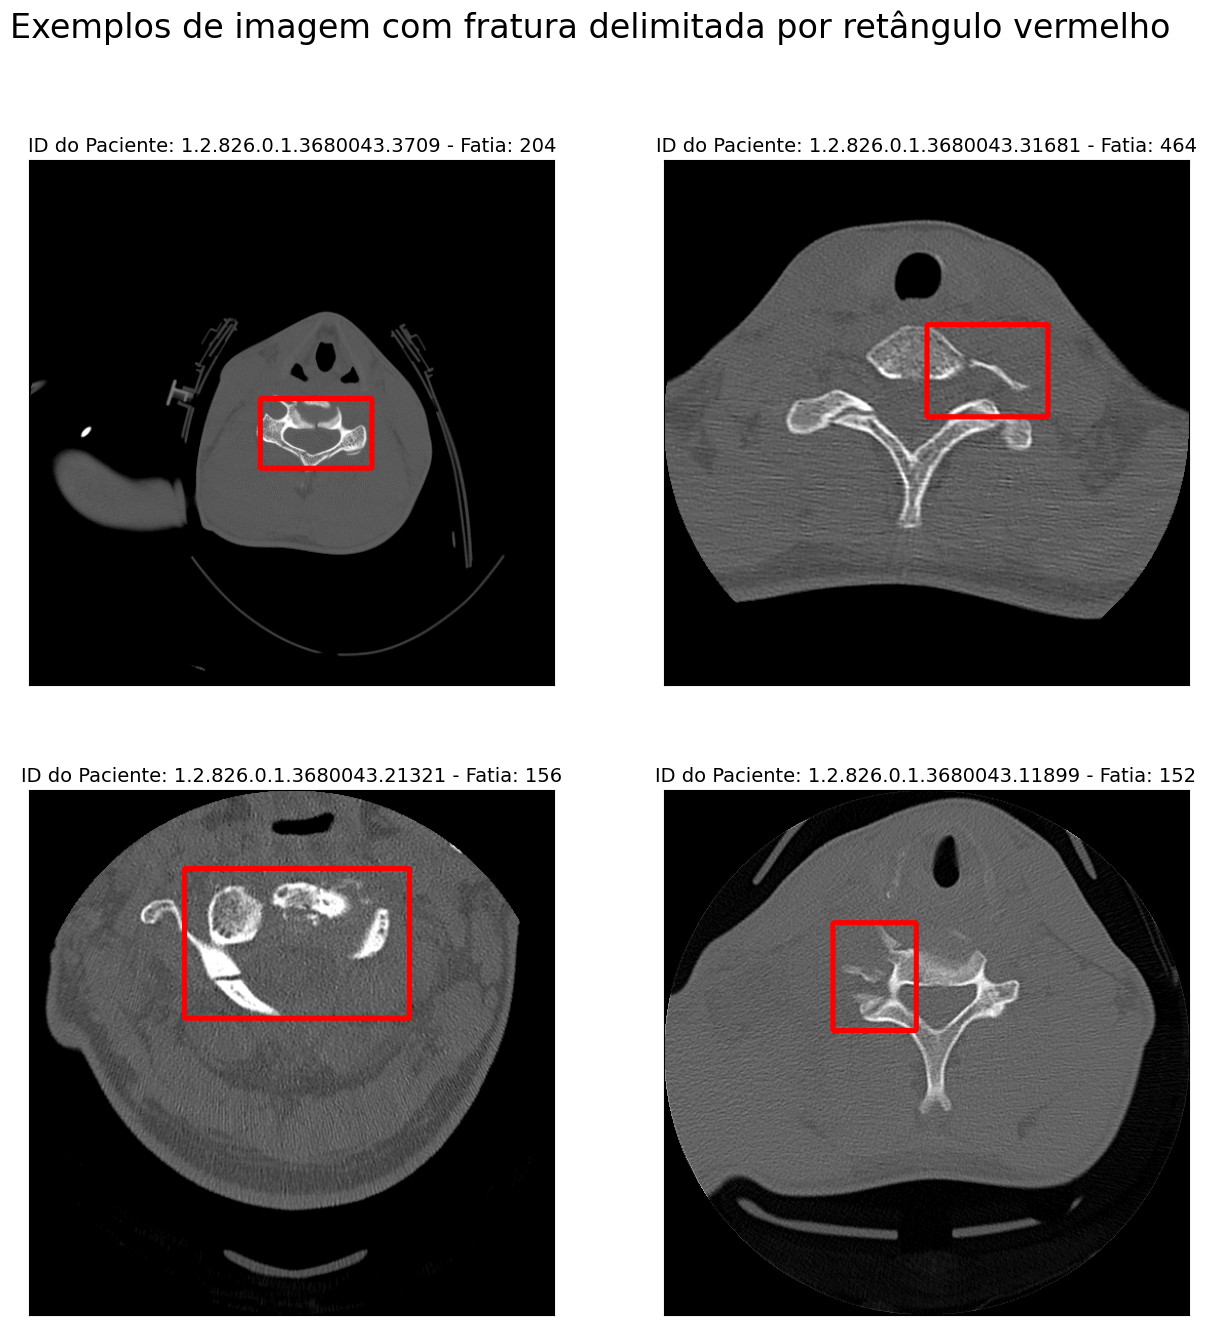

In [29]:
num_examples = 4

sample = train_bb_df.sample(num_examples, random_state=99)
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

def plot_images(num_examples, sample, fig, axs, title, preprocess=True, paint=True):
    for i in range(num_examples):
    # Get info from slice
        slice_row = sample.iloc[i]
        study_id = slice_row.StudyInstanceUID
        slice_number = slice_row.slice_number
        x = int(slice_row.x)
        y = int(slice_row.y)
        width = int(slice_row.width)
        height = int(slice_row.height)

    # Load .dcm file into a PIL Image
        file_path = f"{images_path}/{study_id}/{slice_number}.dcm"
        if preprocess:
            img = (preprocess_single_image(file_path) / 65535 * 255).astype(np.uint8)
        else:
            img = pydicom.dcmread(file_path).pixel_array
            img = (img - np.min(img)) / (np.max(img) - np.min(img))
            img = ((img * 65535).astype(dtype=np.uint16) / 65535 * 255).astype(np.uint8)

        if paint:
            img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
            img = cv.rectangle(img, (x, y), (x+width, y+height), (255,0,0), 3)

    # Plot configs
        if len(img.shape) > 2:
            axs.flatten()[i].imshow(img)
        else:
            axs.flatten()[i].imshow(img, cmap="gray")
        axs.flatten()[i].set_title(f"ID do Paciente: {study_id} - Fatia: {slice_number}", fontsize=14)
        axs.flatten()[i].get_xaxis().set_visible(False)
        axs.flatten()[i].get_yaxis().set_visible(False)
    fig.suptitle(title, fontsize=24)
    plt.show()

plot_images(num_examples, sample, fig, axs, title="Exemplos de imagem com fratura delimitada por retângulo vermelho", preprocess=True, paint=True)

## Examples of images without preprocessing

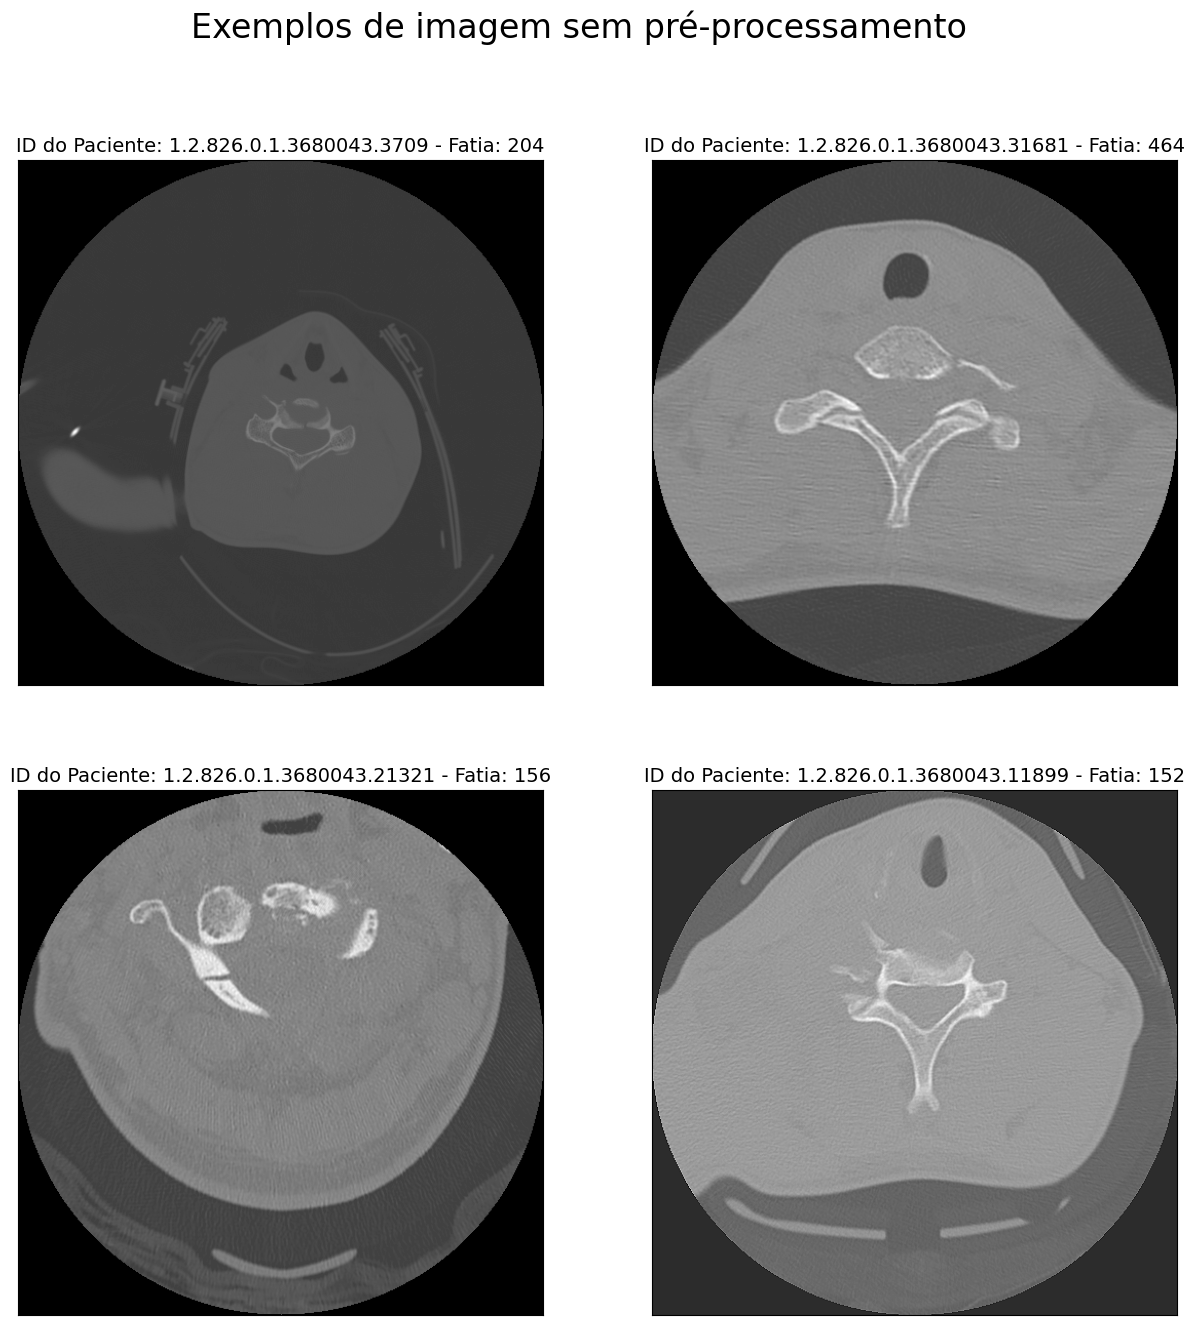

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
plot_images(num_examples, sample, fig, axs, title="Exemplos de imagem sem pré-processamento", preprocess=False, paint=False)

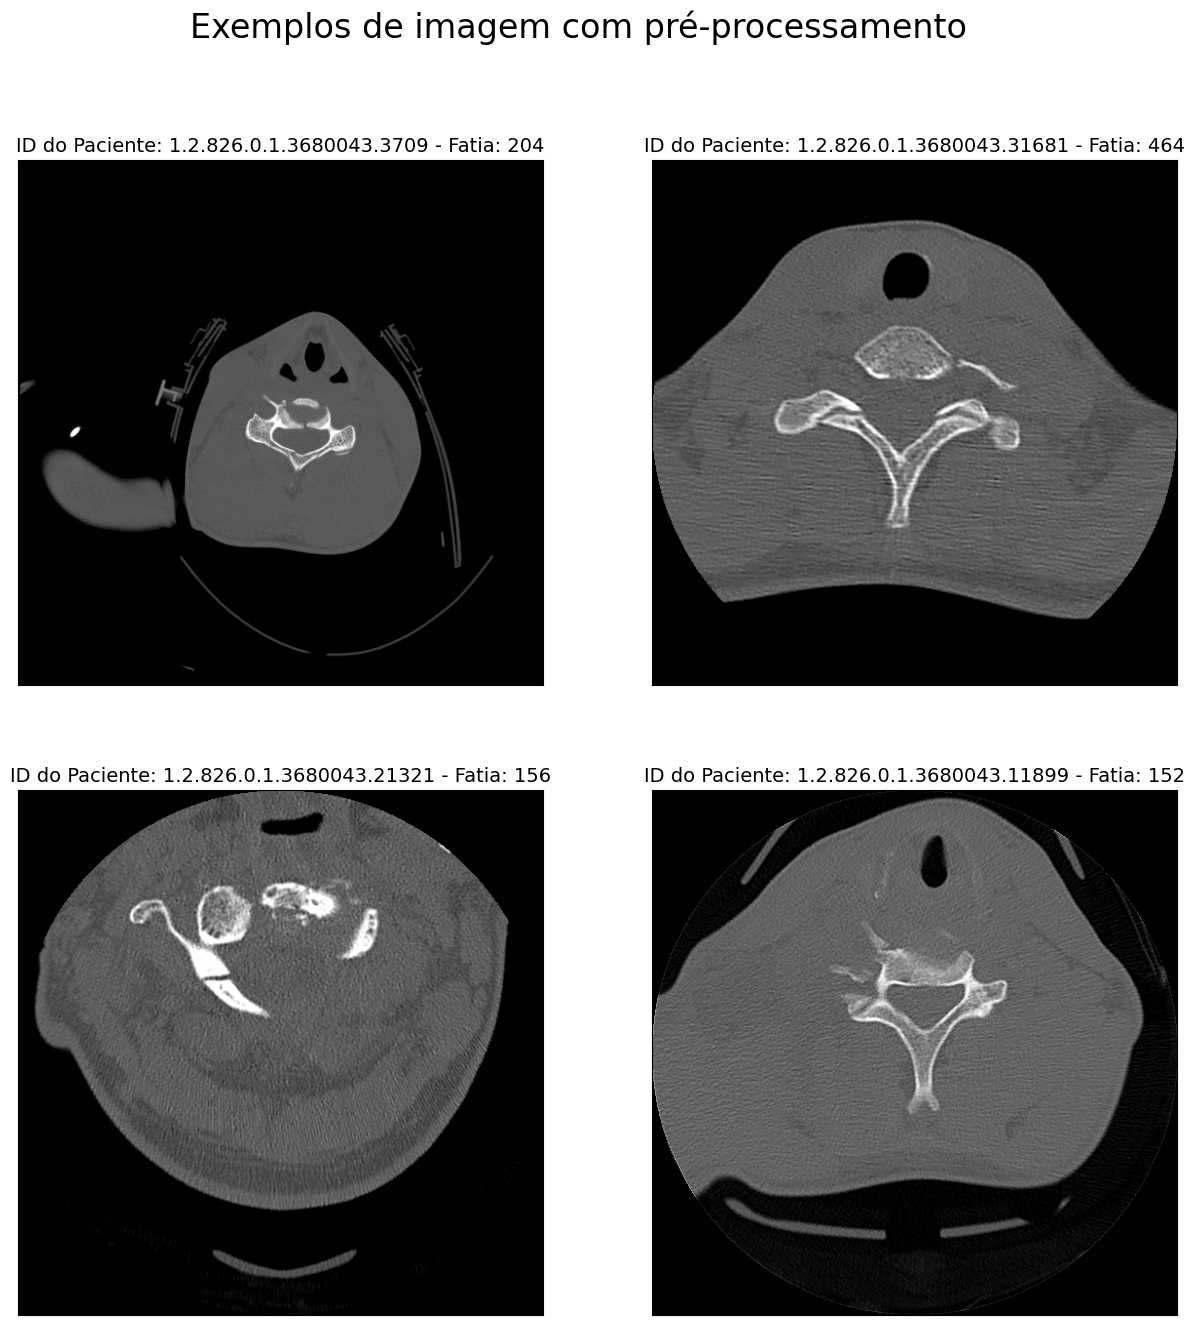

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
plot_images(num_examples, sample, fig, axs, title="Exemplos de imagem com pré-processamento", preprocess=True, paint=False)

## Preprocess images

In [17]:
replace_processed_dataset = True
match_img_size = False
target_img_size = 512

In [18]:
positive_output_path = pjoin("processed_dataset", "positive_images")
negative_output_path = pjoin("processed_dataset", "negative_images")

os.makedirs(positive_output_path, exist_ok=True)
os.makedirs(negative_output_path, exist_ok=True)

In [19]:
# Preprocessing function, can receive a dataframe for positive examples or an array for negative examples
#def preprocess_images(iter, input_images_dir, output_images_dir, gt_df=None, match_img_size=True, target_img_size=512, replace_processed_dataset=True):
def preprocess_images(iter, input_images_dir, output_images_dir, match_img_size=True, target_img_size=512, replace_processed_dataset=True):
    is_df = isinstance(iter, pd.DataFrame)
    if replace_processed_dataset or os.listdir(output_images_dir) == 0:
        for i in range(len(iter)):
            # Get info from slice
            if is_df:
                slice_row = iter.iloc[i]
                study_id = slice_row.StudyInstanceUID
                slice_number = str(slice_row.slice_number)
            else:
                study_id = iter[i].parents[0].name
                slice_number = str(iter[i].name.replace(".dcm", ""))

            # Load .dcm file into a PIL Image
            file_path = pjoin(input_images_dir, study_id, slice_number + ".dcm")
            processed_img = preprocess_single_image(file_path, resize=match_img_size, target_resize=target_img_size)

            os.makedirs(pjoin(output_images_dir, study_id), exist_ok=True)
            # rgb_img = cv.cvtColor(processed_img, cv.COLOR_GRAY2RGB)
            cv.imwrite(pjoin(output_images_dir, study_id, slice_number + ".tif"), processed_img)

#### Preprocessing positive examples

In [20]:
preprocess_images(train_bb_df, images_path, positive_output_path, match_img_size=match_img_size, target_img_size=target_img_size, replace_processed_dataset=replace_processed_dataset)

#### Prepare for preprocess negative examples

In [21]:
negative_study_id_candidates = []

study_uids = list(train_df.loc[(train_df.patient_overall == 0)].StudyInstanceUID)


for dirpath, dirnames, filenames in os.walk(images_path):
    dcm_paths = [Path(pjoin(dirpath, filename)) for filename in filenames]
    for dcm_path in dcm_paths:
        study_uid = str(dcm_path.parents[0].name)

        if study_uid not in study_uids:
            continue

        if os.path.exists(dcm_path):
            negative_study_id_candidates.append(dcm_path)

negative_study_id_candidates = np.array(negative_study_id_candidates)

### Preprocessing negative

In [22]:
np.random.seed(42)
negative_sample = negative_study_id_candidates[
    np.random.choice(range(len(negative_study_id_candidates)), size=7200, replace=False)
]
preprocess_images(negative_sample, images_path, negative_output_path, match_img_size=match_img_size, target_img_size=target_img_size, replace_processed_dataset=replace_processed_dataset)

## Select networks to prepare and train

In [23]:
processed_dataset_path = "processed_dataset"

parameters = {
    "networks": {
        "operations": {
            "prepare_data_yolo" : True,
            "train_yolo" : True,
            "cv" : True
        },

        "train_val_test_split": (0.7, 0.15, 0.15),
        "shuffle": True,
        "shuffle_seed": 87,
    },
    "processed_images_path": f"{processed_dataset_path}",
    "yolo_output_path": f"{processed_dataset_path}/yolo_dataset" # Root dir, all yolo structure will be created
}

### Prepare images for Yolo

In [24]:
import shutil

def get_slice_data_in_yolo_format(bb_df, study_id, slice_number, img_size):
    res = []
    rows = bb_df.loc[(bb_df.StudyInstanceUID == study_id) & (bb_df.slice_number == int(slice_number))]
    for _, row in rows.iterrows():
        x = row.x
        y = row.y
        width = row.width
        height = row.height

        center_x = (x + width / 2.0) / img_size
        center_y = (y + height / 2.0) / img_size
        bbox_width = width / img_size
        bbox_height = height / img_size

        raw_info = [center_x, center_y, bbox_width, bbox_height]
        res.append((str(float(np.clip(element, 0.0, 1.0))) for element in raw_info))
    return res

def get_train_val_test_split_images(input_images_path, train_val_test_split, shuffle, shuffle_seed):
    # images_full_path = []
    images_study_to_slices = dict()
    print(f"Reading path: {input_images_path}")
    for study_id in os.listdir(input_images_path):
        if study_id not in images_study_to_slices.keys():
            images_study_to_slices[study_id] = []

        study_id_path = f"{input_images_path}/{study_id}"
        assert os.path.isdir(study_id_path), f"The path '{study_id_path}' is not a directory."

        for jpg_image in os.listdir(study_id_path):
            jpg_image_path = f"{study_id_path}/{jpg_image}"
            assert jpg_image_path.endswith(".tif"), f"The path '{jpg_image_path}' is not a tif file."

            images_study_to_slices[study_id].append(jpg_image_path)
            # images_full_path.append(jpg_image_path)

    assert sum(train_val_test_split) == 1.0

    sorted_study_keys = np.array(sorted(images_study_to_slices.keys()))
    # images_full_path = np.array(images_full_path)

    np.random.seed(shuffle_seed)
    images_indexes = np.arange(len(sorted_study_keys))
    if shuffle:
        np.random.shuffle(images_indexes)

    # Split images in train, validation and test
    train_proportion, val_proportion, test_proportion = train_val_test_split # Test_proportion is maintained only for semantics

    train_split_limit = int(train_proportion * len(sorted_study_keys))
    val_split_limits = (int(train_split_limit), int((train_proportion + val_proportion) * len(sorted_study_keys)))
    test_split_limit = int(val_split_limits[1])

    train_images = access_keys_by_index_and_extend_elements(images_study_to_slices, sorted_study_keys, images_indexes, slice(0, train_split_limit))
    val_images = access_keys_by_index_and_extend_elements(images_study_to_slices, sorted_study_keys, images_indexes, slice(val_split_limits[0], val_split_limits[1]))
    test_images = access_keys_by_index_and_extend_elements(images_study_to_slices, sorted_study_keys, images_indexes, slice(test_split_limit, None))
    print(f"Number of train images: {len(train_images)}\nNumber of val images: {len(val_images)}\nNumber of test images: {len(test_images)}")

    return train_images,val_images,test_images

def access_keys_by_index_and_extend_elements(images_study_to_slices, sorted_study_keys, images_indexes, specific_slice):
    images = []
    for element in list(map(lambda x: images_study_to_slices[x],sorted_study_keys[images_indexes[specific_slice]])):
        images.extend(element)
    return np.array(images)

def prepare_data_yolo(input_images_path, yolo_output_path, train_val_test_split=(0.7, 0.15, 0.15), shuffle=True, shuffle_seed=42):
    negative_train_images, negative_val_images, negative_test_images = \
        get_train_val_test_split_images(pjoin(input_images_path, "negative_images"), train_val_test_split, shuffle, shuffle_seed)
    positive_train_images, positive_val_images, positive_test_images = \
        get_train_val_test_split_images(pjoin(input_images_path, "positive_images"), train_val_test_split, shuffle, shuffle_seed)
    
    train_images = np.concatenate((negative_train_images, positive_train_images))
    val_images = np.concatenate((negative_val_images, positive_val_images))
    test_images = np.concatenate((negative_test_images, positive_test_images))

    # Make yolo sub structure
    os.makedirs(yolo_output_path, exist_ok=True)
    os.makedirs(pjoin(yolo_output_path,"images"), exist_ok=True)
    # os.makedirs(pjoin(yolo_output_path, "labels"), exist_ok=True)

    for set_name, set_images in zip(("train", "val", "test"), (train_images, val_images, test_images)):
        # yolo_images_set_path = pjoin(yolo_output_path, set_name)
        yolo_images_set_path = pjoin(yolo_output_path, "images", set_name)
        yolo_labels_set_path = pjoin(yolo_output_path, "labels", set_name)
        os.makedirs(yolo_images_set_path, exist_ok=True)
        os.makedirs(yolo_labels_set_path, exist_ok=True)
        
        for image_path in set_images:
            study_id = image_path.split("/")[-2]
            image_name_no_suffix = image_path.split("/")[-1].split(".")[0]

            full_img_name_no_suffix = study_id + "_" + image_name_no_suffix

            img = cv.imread(image_path)
            assert not(img is None)
            
            shutil.copy(image_path, pjoin(yolo_images_set_path, full_img_name_no_suffix + ".tif"))
            # This saves the labels into a separate folder from the images
            # with open(pjoin(yolo_labels_set_path, full_img_name_no_suffix + ".txt"), "w") as f:
            with open(pjoin(yolo_labels_set_path, full_img_name_no_suffix + ".txt"), "w") as f:
                # f.write("# class_id center_x center_y bbox_width bbox_height\n")
                res = get_slice_data_in_yolo_format(train_bb_df, study_id, image_name_no_suffix, img.shape[0])
                
                i = None
                for i, (c_x, c_y, bb_w, bb_h) in enumerate(res):
                    f.write(f"0 {str(c_x)} {c_y} {bb_w} {bb_h}\n")
                
                if i == None:
                    f.write("\n")

    
prepare_data_yolo(input_images_path=parameters["processed_images_path"],
                  yolo_output_path=parameters["yolo_output_path"],
                  train_val_test_split=parameters["networks"]["train_val_test_split"],
                  shuffle=parameters["networks"]["shuffle"],
                  shuffle_seed=parameters["networks"]["shuffle_seed"])

Reading path: processed_dataset\negative_images
Number of train images: 5055
Number of val images: 1083
Number of test images: 1062
Reading path: processed_dataset\positive_images
Number of train images: 5122
Number of val images: 940
Number of test images: 1155


## Customize yaml config

## Train network

In [ ]:
yolo task=detect mode=train model="yolov8m.yaml" data=dataset.yaml batch=17 cache=True optimizer='auto' epochs=400 imgsz=512 patience=20 translate=0.28 degrees=90.0 workers=16 mosaic=1.0 fliplr=0.5 flipud=0.5 scale=0.5 dropout=0.22

### Evaluation

### Inference